In [4]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import geoplot.crs as gcrs
import geoplot as gplt
import pyproj
from tqdm import tqdm
from collections import defaultdict
from shapely.geometry import LineString
import networkx as nx
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import Point, box
from shapely.geometry import Polygon
import matplotlib.patches as mpatches
from shapely.geometry import LineString
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, LineString, Point, MultiLineString
import networkx as nx
import matplotlib.pyplot as plt
import json

In [5]:
# streets = gpd.read_file('train_dataset_codd_train/vector/Streets_исходные.shp')
streets = gpd.read_file('train_dataset_codd_train/vector/Streets_1очередь.shp')
gdf = gpd.read_file('train_dataset_codd_train/vector/House_1очередь_ЖК.shp')
minx, miny, maxx, maxy = gdf.total_bounds
bounding_box2 = box(minx+100, miny+100, maxx+100, maxy+100)
bounding_box = box(minx, miny, maxx, maxy)
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs=gdf.crs)
streets2 = streets[streets.within(bounding_box)]
streets2_1 = streets[streets.within(bounding_box2)]

In [175]:
# difference_gdf = gpd.overlay(streets, streets2, how='difference')

In [6]:
minx, miny, maxx, maxy = gdf.total_bounds
bounding_box2 = box(minx+100, miny+100, maxx+100, maxy+100)
bounding_box = box(minx, miny, maxx, maxy)
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs=gdf.crs)

streets2 = streets[streets.within(bounding_box)]
streets2_1 = streets[streets.within(bounding_box2)]

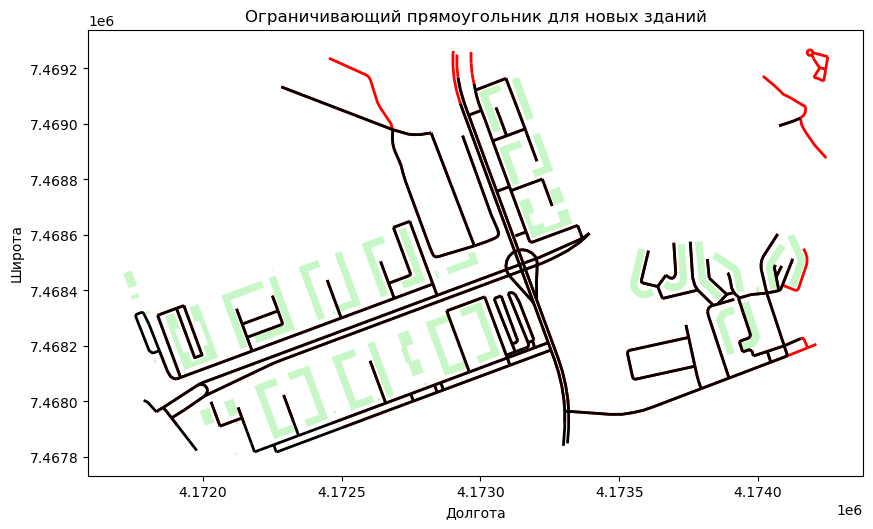

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="lightgreen", alpha=0.5)
streets2_1.plot(ax=ax, color="red", linewidth=2)
streets2.plot(ax=ax, color="black", linewidth=2)
# Добавляем заголовок и метки
plt.title("Ограничивающий прямоугольник для новых зданий")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

In [8]:
%%time
def createGraph(humon_road):
    G = nx.Graph()
    for idx, row in humon_road.iterrows():
        geometry = row['geometry']
        if isinstance(geometry, LineString) and row['Foot'] == 1:
            coords = list(geometry.coords)
            for i in range(len(coords) - 1):
                start = coords[i]
                end = coords[i + 1]
                if row['RoadDirect'] == 'F':
                    G.add_edge(start, end, weight=1)
                elif row['RoadDirect'] == 'T':
                    G.add_edge(end, start, weight=1)
                elif row['RoadDirect'] == 'Any':
                    G.add_edge(start, end, weight=1)
                    G.add_edge(end, start, weight=1)
    return G     
G = createGraph(streets2)
G2 = createGraph(streets2_1)

CPU times: total: 31.2 ms
Wall time: 33 ms


In [9]:
G = createGraph(streets2)
G2 = createGraph(streets2_1)

In [10]:
nodes = []
for i in G.nodes():
    cnt = 0
    for j in G.edges():
        if i in j:
            cnt += 1
    for j in G2.edges():
        if i in j:
            cnt += 1
        
    if cnt == 2:
        nodes.append(i)

In [11]:
nodes = [Point(i) for i in nodes]
for idx, building in gdf.iterrows():
    buildings = building.geometry 
    buffer_distance = 20
    buffered_buildings = buildings.buffer(buffer_distance)
    combined_buffer = buffered_buildings.unary_union if hasattr(buffered_buildings, 'unary_union') else buffered_buildings
    simplified_buffer = combined_buffer.simplify(15)
    boundary = simplified_buffer.boundary
    G = nx.Graph()
    lines = [boundary] if isinstance(boundary, LineString) else list(boundary.geoms)
    for line in lines:
        nodes += [Point(i) for i in list(line.coords)]


In [213]:
len(nodes)

379

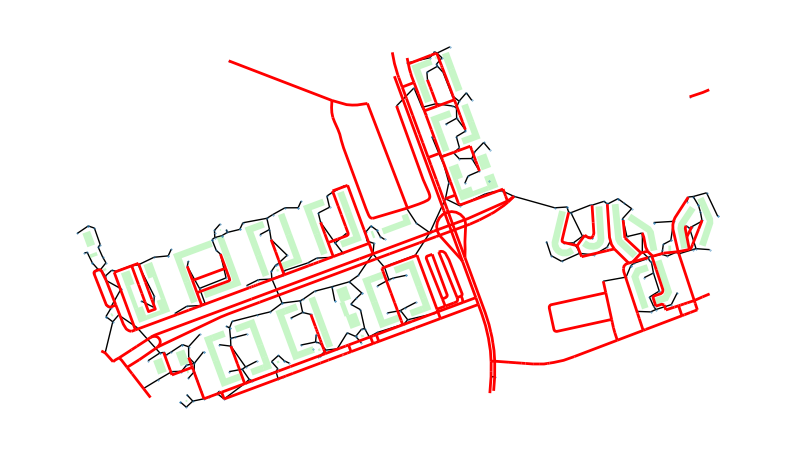

In [15]:
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
import networkx as nx
import random
import numpy as np

G = nx.Graph()

for i, node in enumerate(nodes):
    G.add_node(i, pos=(node.x, node.y))

for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        line = LineString([nodes[i], nodes[j]])
        if not any(line.intersects(building) for building in gdf.geometry):
            distance = nodes[i].distance(nodes[j])
            if distance <= 250:
                G.add_edge(i, j, weight=distance)
        

# Использование алгоритма минимального остовного дерева
mst = nx.minimum_spanning_tree(G)

# Визуализация графа
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.get_node_attributes(mst, 'pos')
nx.draw(mst, pos, with_labels=False, node_size=0.1)
gdf.plot(ax=ax, color="lightgreen", alpha=0.5)
streets2.plot(ax=ax, color="red", linewidth=2)

plt.show()
